Draft to measure emmsion lines.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from scipy.interpolate import interpolate
from craftroom import resample
from astropy.convolution import convolve, Box1DKernel
from astropy.modeling import models, fitting
from scipy.optimize import leastsq
from astropy.modeling import functional_models
from matplotlib.gridspec import GridSpec

#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20


In [2]:
# path = '/media/david/1tb_storage1/emergency_data/mega_muscles/v01_seds/'
path = '/media/david/2tb_ext_hd/hddata/mega_muscles/v10_seds/'

In [3]:
hdul = fits.open('{}hlsp_muscles_multi_multi_gj1132_broadband_v10_var-res-sed.fits'.format(path))

In [4]:
data = hdul[1].data
inst_list = hdul[2].data
inst_list

FITS_rec([(     1, 'HST', 'COS', 'G130M', 'hlsp_muscles_hst_cos_gj1132_g130m_v10_component-spec.fits'),
          (     2, 'HST', 'COS', 'G160M', 'hlsp_muscles_hst_cos_gj1132_g160m_v10_component-spec.fits'),
          ( 65536, 'MOD', 'LYA', 'YOUNG', 'hlsp_muscles_mod_lya_gj1132_young_v10_component-spec.fits'),
          (     8, 'HST', 'STS', 'G140M', 'hlsp_muscles_hst_sts_gj1132_g140m_v10_component-spec.fits'),
          (   128, 'HST', 'STS', 'G230L', 'hlsp_muscles_hst_sts_gj1132_g230l_v10_component-spec.fits'),
          (  1024, 'MOD', 'GAP', 'FILL-', 'hlsp_muscles_mod_gap_gj1132_fill-_v10_component-spec.fits'),
          (131072, 'MOD', 'PHX', 'NA', 'hlsp_muscles_mod_phx_gj1132_na_v10_component-spec.fits'),
          (   256, 'HST', 'STS', 'G430L', 'hlsp_muscles_hst_sts_gj1132_g430l_v10_component-spec.fits'),
          (  2048, 'XMM', 'EPC', 'MULTI', 'hlsp_muscles_xmm_epc_gj1132_multi_v10_component-spec.fits'),
          ( 32768, 'MOD', 'APC', 'NA', 'hlsp_muscles_mod_apc_gj1132_na

In [5]:
mask = (data['WAVELENGTH'] > 1160) & (data['WAVELENGTH'] < 2000) & (data['INSTRUMENT'] != 65536)

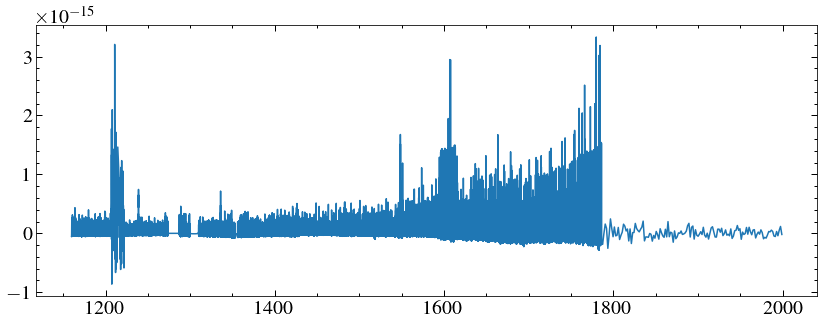

In [6]:
plt.plot(data['WAVELENGTH'][mask], data['FLUX'][mask])

In [7]:
line_list = Table.read('all_linelist.csv')

(1160.0, 1700.0)

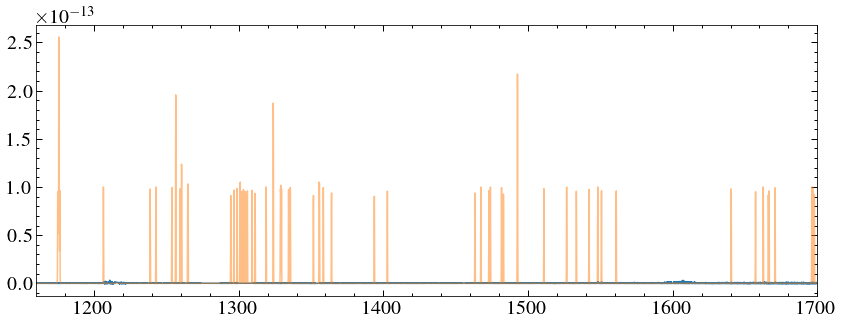

In [8]:
mod1 = models.Const1D(0)
for i in range(len(line_list)):
    amp = 1e-13
#     if line_list['Likelihood to measure'][i] == 'Low':
#         amp = amp/3
#     if line_list['Likelihood to measure'][i] == 'Medium':
#         amp = amp/2
    if line_list['Likelihood to measure'][i] in ['High', 'Medium']:
#     mod1 = mod1+ functional_models.Voigt1D(x_0=line_list['Wavelength'][i], amplitude_L=amp, fwhm_G=0.05, fwhm_L=0.05)
        mod1 = mod1 + models.Gaussian1D(amplitude=amp, mean = line_list['Wavelength'][i], stddev=0.1)


mw = np.arange(900, 1700, 0.1)
plt.plot(data['WAVELENGTH'][mask], data['FLUX'][mask])
plt.plot(mw, mod1(mw), alpha=0.5)
plt.xlim(1160, 1700)


In [9]:
# stars =[]
# for j, spec in enumerate(specs):
#     star = fits.getheader(spec)['TARGNAME']
#     stars.append(star)
# print(stars)

In [10]:
specs = glob.glob('{}*_var*'.format(path))
specs

['/media/david/2tb_ext_hd/hddata/mega_muscles/v10_seds/hlsp_muscles_multi_multi_gj1132_broadband_v10_var-res-sed.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/v10_seds/hlsp_muscles_multi_multi_gj15a_broadband_v10_var-res-sed.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/v10_seds/hlsp_muscles_multi_multi_gj163_broadband_v10_var-res-sed.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/v10_seds/hlsp_muscles_multi_multi_gj649_broadband_v10_var-res-sed.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/v10_seds/hlsp_muscles_multi_multi_gj676a_broadband_v10_var-res-sed.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/v10_seds/hlsp_muscles_multi_multi_gj699_broadband_v10_var-res-sed.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/v10_seds/hlsp_muscles_multi_multi_gj729_broadband_v10_var-res-sed.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/v10_seds/hlsp_muscles_multi_multi_gj849_broadband_v10_var-res-sed.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/

What about just doublets to get the rv?

Measuring clean doublets that are detected in all stars to get velocities

GJ1132
0
4.4 km / s
Model: Voigt1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
           x_0             amplitude_L             fwhm_L               fwhm_G       
    ----------------- ---------------------- ------------------ ---------------------
    1242.944312041775 1.3889578654126881e-16 0.1332481670995872 -0.008579628880722032
1238.821 33.95526221361638 km / s 1.1597355471885074 km / s
1242.804 33.84644070237438 km / s 1.15601876910004 km / s
Model: Voigt1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
           x_0             amplitude_L             fwhm_L               fwhm_G      
    ------------------ -------------------- -------------------- -------------------
    1335.9088981506084 9.08252018957767e-15 0.006559553958786489 0.22525244901544744
1334.524 44.90586750068188 km / s 1.062307690260969 km / s
1335.709 44.86602839430257 km / s 1.0613652435378285 km / s
Model: Voigt1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
  

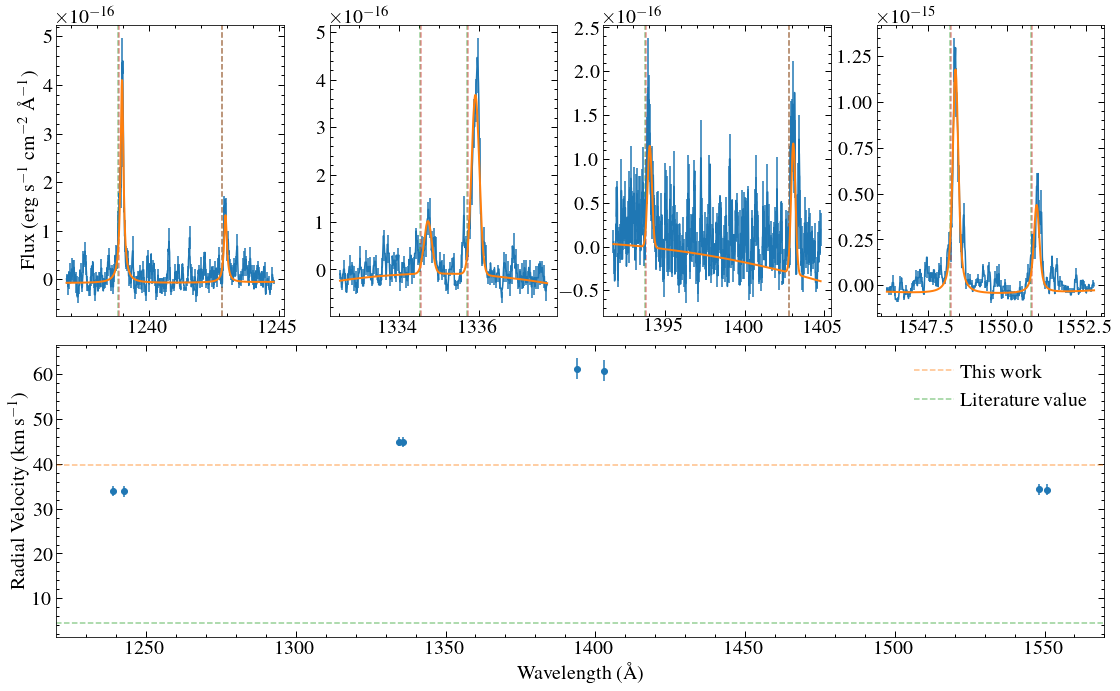

GJ15A
1
11.6 km / s
1238.821 -9.559433396363447 km / s 0.3881296858157368 km / s
1242.804 -9.528796849303351 km / s 0.38688578853489464 km / s
1334.524 -9.578376048728218 km / s 0.3690660060321065 km / s
1335.709 -9.569878407704259 km / s 0.36873858201312526 km / s
1393.755 -4.111483397058285 km / s 0.707907119986775 km / s
1402.77 -4.085060660038945 km / s 0.7033577051223208 km / s


/home/david/anaconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: divide by zero encountered in true_divide


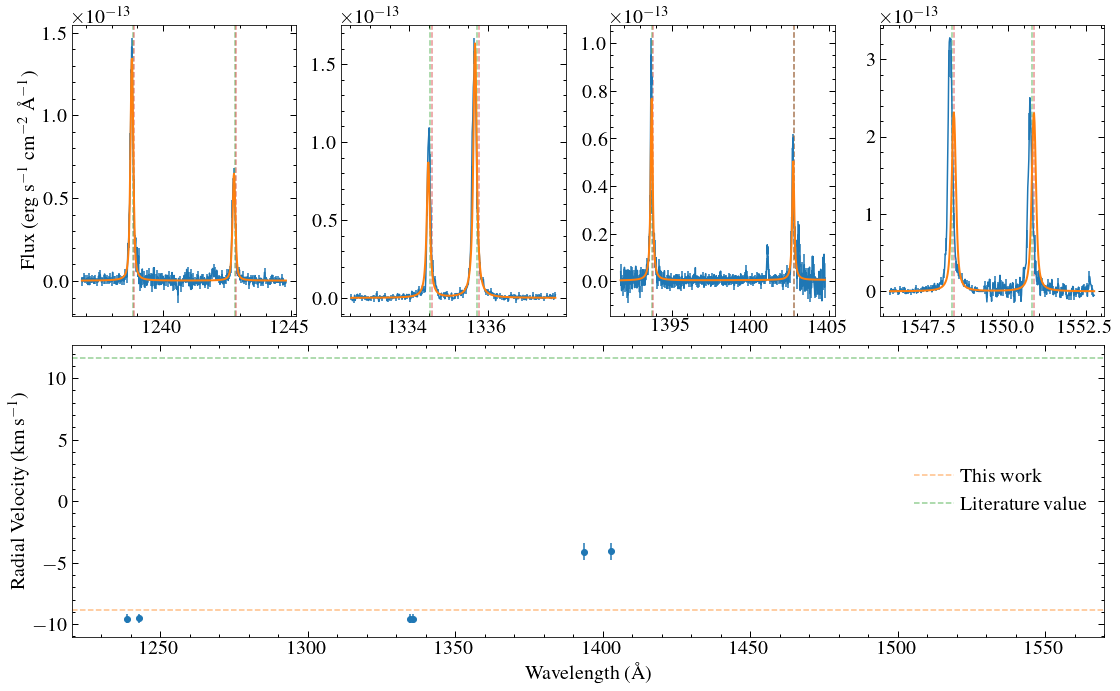

GJ163
2
36.9 km / s
1238.821 43.8857697306523 km / s 0.8126913602747976 km / s
1242.804 43.74512243562447 km / s 0.8100868066393225 km / s
1334.524 56.46749395575779 km / s 0.42703786968573 km / s
1335.709 56.41739772949479 km / s 0.4266590147905269 km / s
1393.755 55.79298258869179 km / s 1.3153015840998705 km / s
1402.77 55.4344250645877 km / s 1.3068487060224 km / s
1548.201 -31.4321223420424 km / s 0.5497759860741116 km / s
1550.772 -31.38001153109724 km / s 0.5488645212858216 km / s


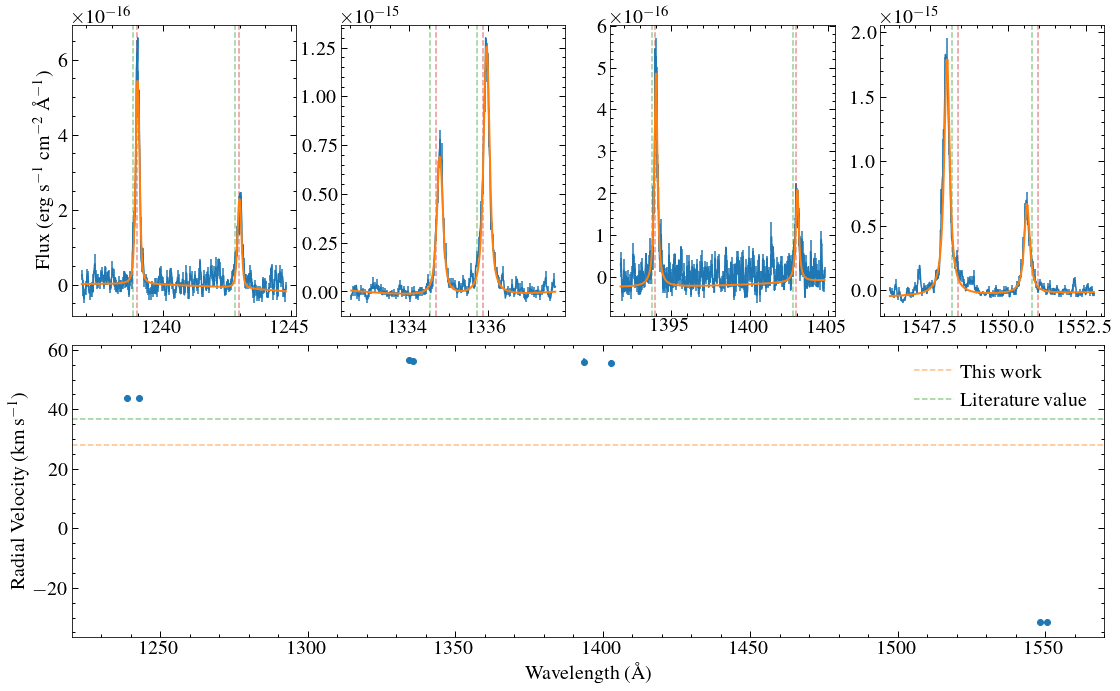

GJ649
3
4.4 km / s
1238.821 -2.6055761719458914 km / s 0.26186096610861553 km / s
1242.804 -2.5972256920129158 km / s 0.2610217410673006 km / s
1334.524 -3.5236369979595863 km / s 0.18703253668743747 km / s
1335.709 -3.520510935443245 km / s 0.18686660717979842 km / s
1393.755 67.79287489434465 km / s 11.70098191250279 km / s
1402.77 67.35719921899997 km / s 11.625784729823792 km / s
1548.201 91.17287637212144 km / s 11.463518156482124 km / s
1550.772 91.0217223241846 km / s 11.444512973793245 km / s


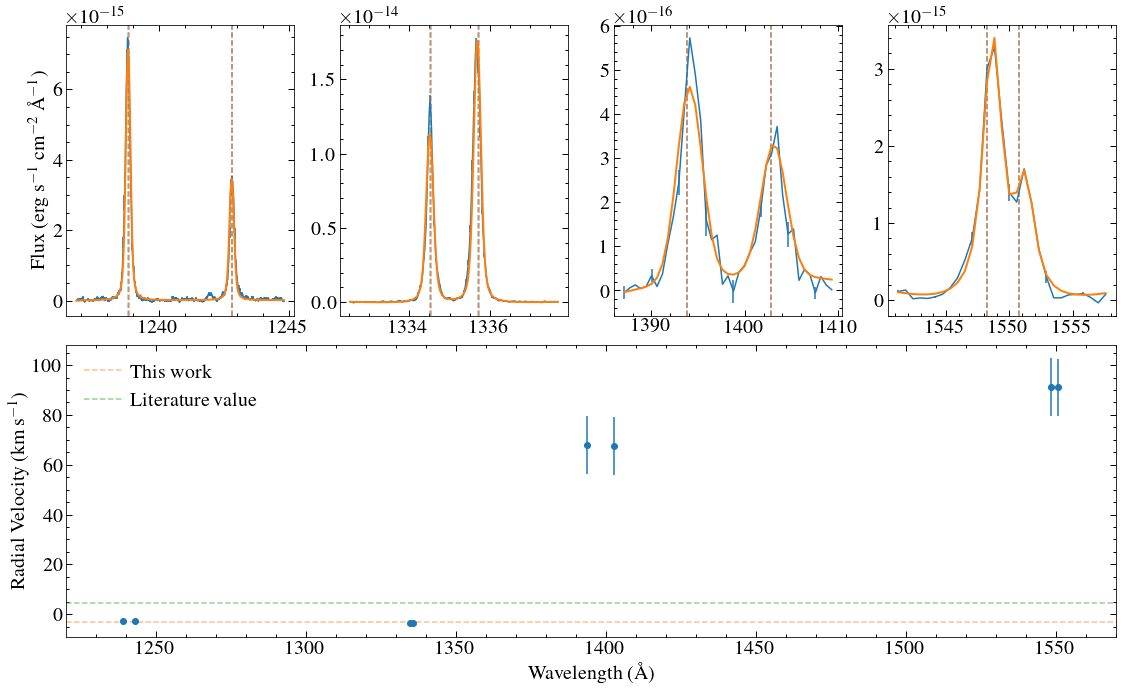

GJ676A
4
-39.1 km / s
1238.821 -44.0604628099457 km / s 0.21628258731584182 km / s
1242.804 -43.9192556498601 km / s 0.2155894341414566 km / s
1334.524 -45.90571620360587 km / s 0.17181371688052494 km / s
1335.709 -45.8649900621207 km / s 0.17166128903485856 km / s
1393.755 -60.37554258210439 km / s 11.852583069664416 km / s
1402.77 -59.98753491416234 km / s 11.776411611491543 km / s
1548.201 -18.34403731883952 km / s 11.361674855937013 km / s
1550.772 -18.313625033910657 km / s 11.342838517621248 km / s


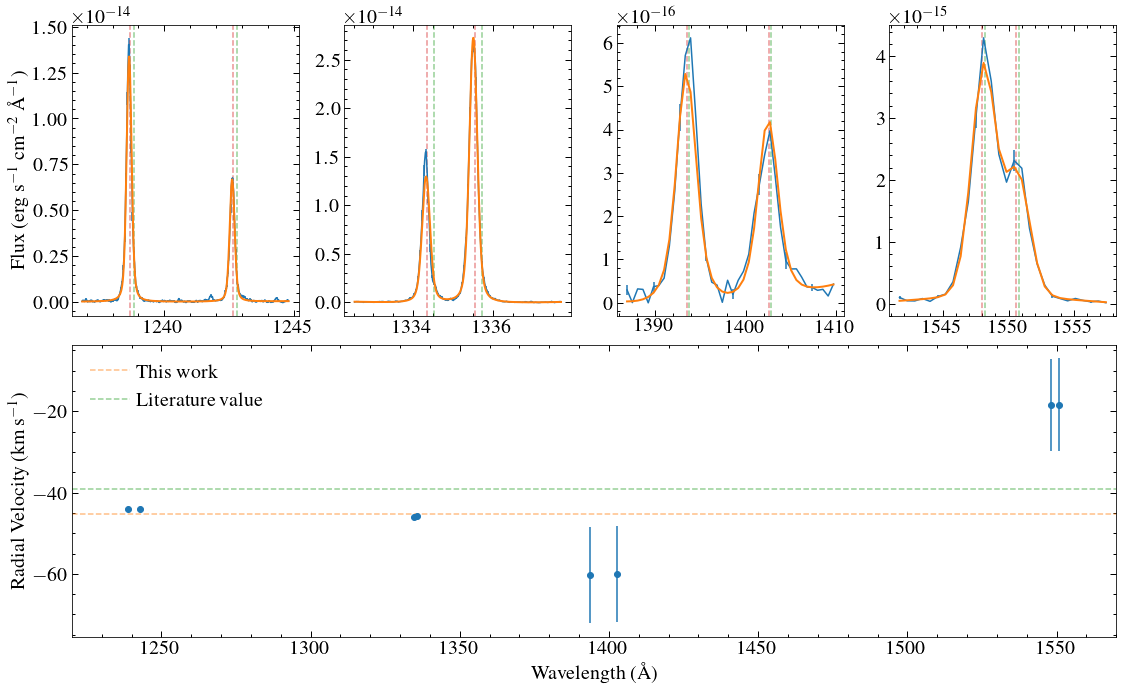

GJ699
5
-110.5 km / s
1238.821 -131.44406504525557 km / s 0.4017841566980991 km / s
1242.804 -131.02280657566575 km / s 0.40049649887443195 km / s
1334.524 -119.29150755682231 km / s 0.31321959546112055 km / s
1335.709 -119.18567579521195 km / s 0.312941716649874 km / s
1393.755 -66.20907875495325 km / s 46.54244730048465 km / s
1402.77 -65.7835814567693 km / s 46.24333899160793 km / s


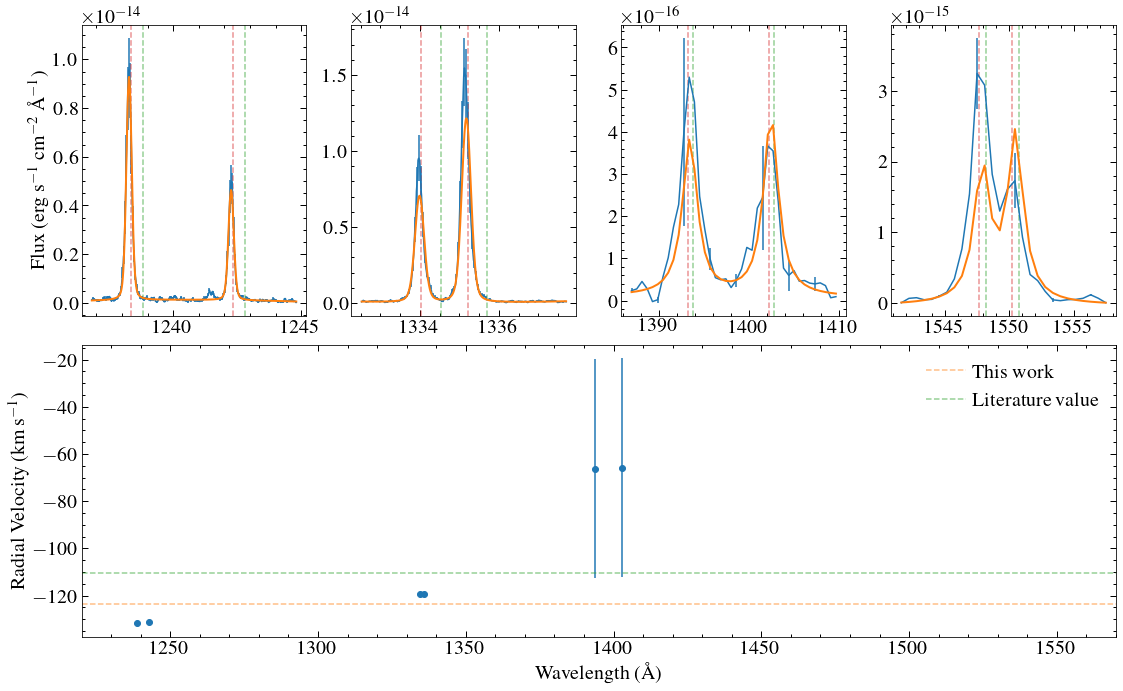

GJ729
6
-10.5 km / s
1238.821 0.519601567685079 km / s 6.537777444221865 km / s
1242.804 0.5179363227570344 km / s 6.516824850277239 km / s
1334.524 11.093577742727884 km / s 0.9495275284206182 km / s
1335.709 11.083735861260998 km / s 0.9486851367729434 km / s
1393.755 16.08088026477613 km / s 2.027752240076831 km / s
1402.77 15.977535357497649 km / s 2.0147207477890854 km / s
1548.201 13.653740941121244 km / s 1.1202455868857628 km / s
1550.772 13.631104623233245 km / s 1.1183883496887708 km / s


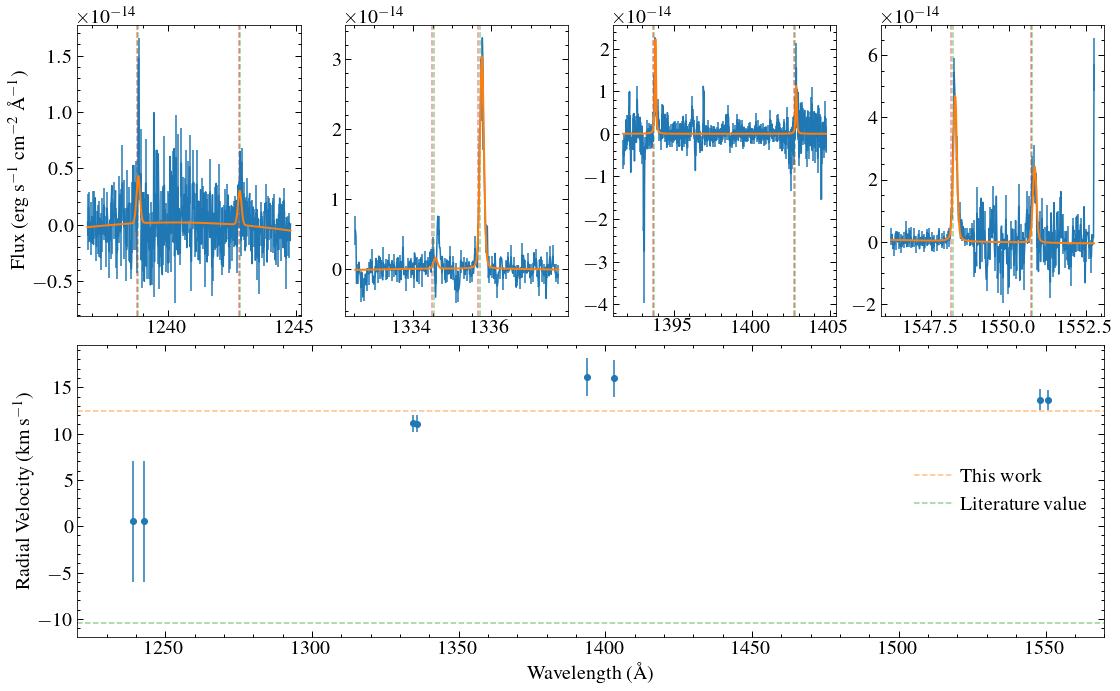

GJ849
7
-15.3 km / s
1238.821 -25.645342206645292 km / s 0.22259394947192135 km / s
1242.804 -25.563152739910848 km / s 0.22188056930817268 km / s
1334.524 -20.412025638078603 km / s 0.20894883763544847 km / s
1335.709 -20.393916715857692 km / s 0.20876346465218454 km / s
1393.755 -14.847235217711676 km / s 0.5157152583488314 km / s
1402.77 -14.751818417033398 km / s 0.5124009779959007 km / s
1548.201 -29.439967619870565 km / s 0.21351855194776803 km / s
1550.772 -29.39115957024012 km / s 0.21316456296714037 km / s


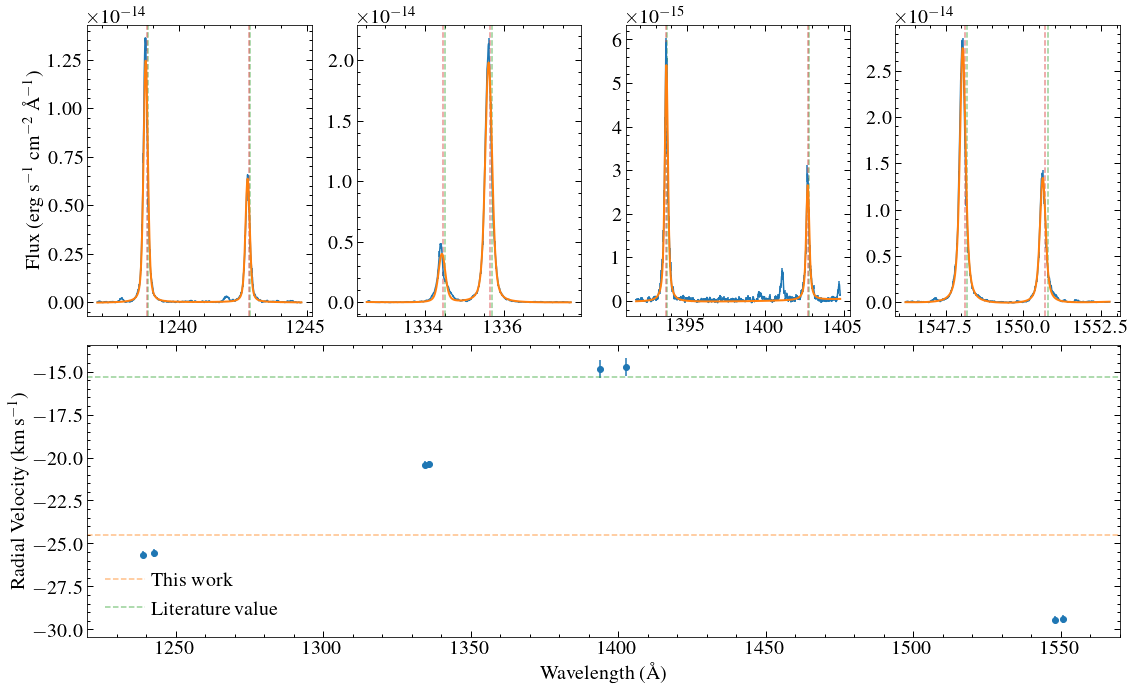

LHS-2686
8
-10.0 km / s
1238.821 7.127847895368947 km / s 0.24782373602589258 km / s
1242.804 7.105004214290377 km / s 0.2470294981962886 km / s
1334.524 4.530546120629022 km / s 0.25657515202559145 km / s
1335.709 4.526526759290356 km / s 0.25634752641521397 km / s
1393.755 -112.17467434577776 km / s 31.89988978231117 km / s
1402.77 -111.45377591680268 km / s 31.69488289851494 km / s
1548.201 -26.16988517428984 km / s 57.89037229282074 km / s
1550.772 -26.126498541836675 km / s 57.794396774089165 km / s


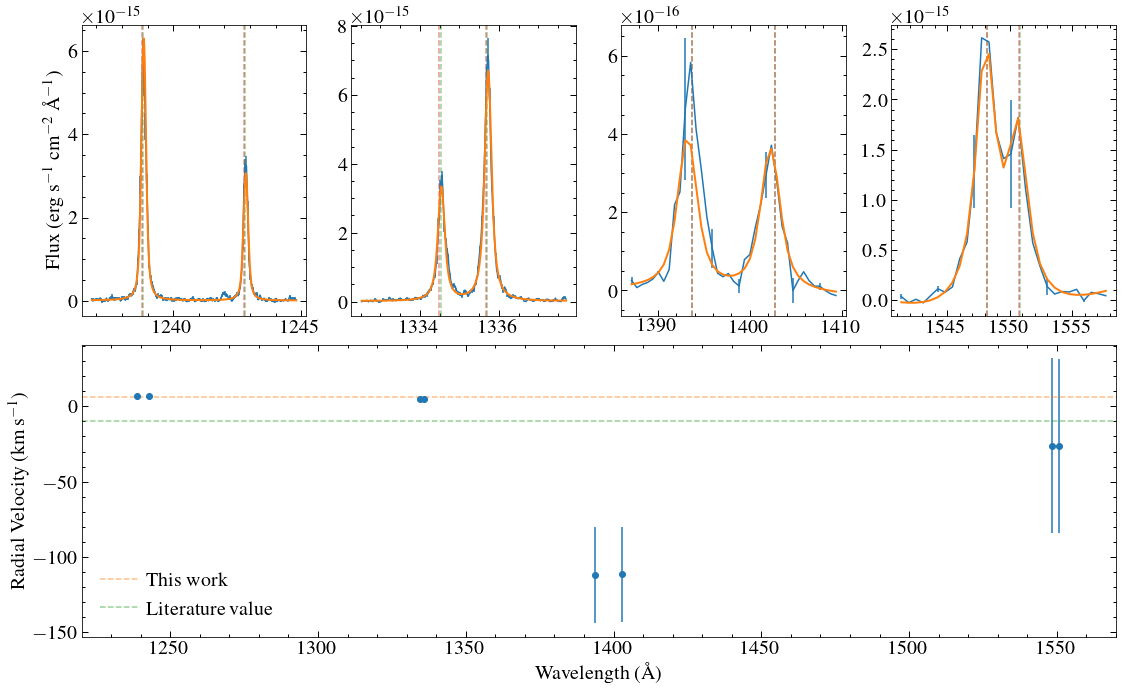

2MASS-J23062928-0502285
9
-54.0 km / s
1238.821 -79.38073486144008 km / s 7.400275692371437 km / s
1242.804 -79.12633153880192 km / s 7.376558921203824 km / s
1334.524 -65.49408217755054 km / s 1.85030893884527 km / s
1335.709 -65.43597783941573 km / s 1.8486674015774618 km / s
1393.755 -52.491739193922356 km / s 6.662318445558583 km / s
1402.77 -52.1543973425503 km / s 6.619502587811066 km / s
1548.201 -58.15796940174787 km / s 2.609380154026688 km / s
1550.772 -58.06155023805356 km / s 2.6050541045487563 km / s


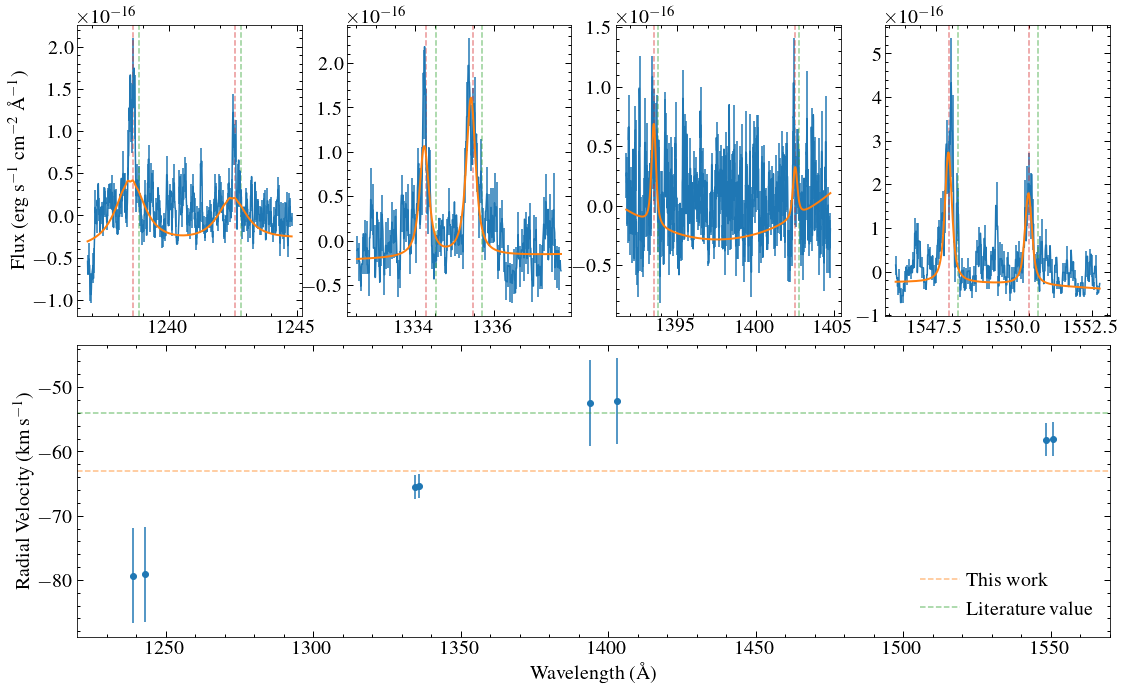

GJ674
10
-2.7 km / s
1238.821 -6.010564978238475 km / s 0.558508098689066 km / s
1242.804 -5.991302020977606 km / s 0.5567181641921932 km / s
1334.524 -9.92751006367076 km / s 0.39708711284112574 km / s
1335.709 -9.918702681681324 km / s 0.39673482936459603 km / s
1393.755 -47.681775862467504 km / s 19.774114352334493 km / s
1402.77 -47.3753455785171 km / s 19.647034616593544 km / s
1548.201 -22.287335549408215 km / s 24.195019849689707 km / s
1550.772 -22.250385733654706 km / s 24.154907314722713 km / s


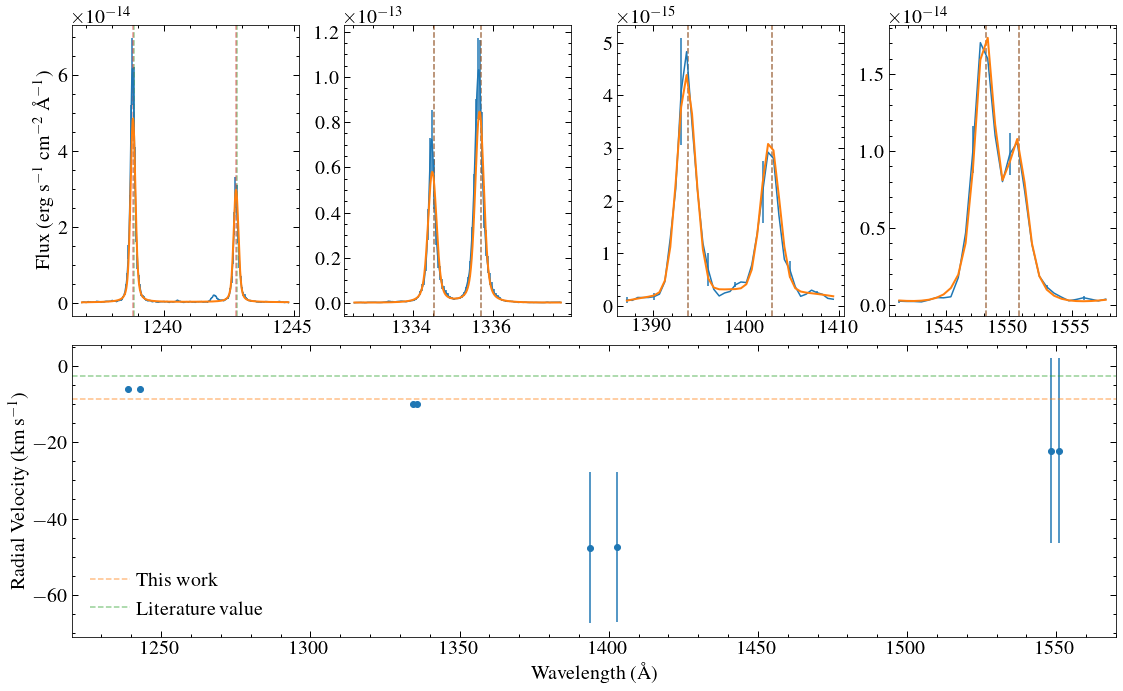

L-980-5
11
-11.3 km / s
1238.821 1.4221204409839627 km / s 0.7046045697070337 km / s
1242.804 1.4175627587606623 km / s 0.7023464179445551 km / s
1334.524 19.699577894554064 km / s 0.6036773456494 km / s
1335.709 19.682101034118777 km / s 0.603141781682691 km / s
1393.755 25.558373356599965 km / s 1.1977368203054723 km / s
1402.77 25.394120673802885 km / s 1.1900394804267318 km / s
1548.201 15.234285830104676 km / s 0.855534480559319 km / s
1550.772 15.20902915224288 km / s 0.8541161036507532 km / s


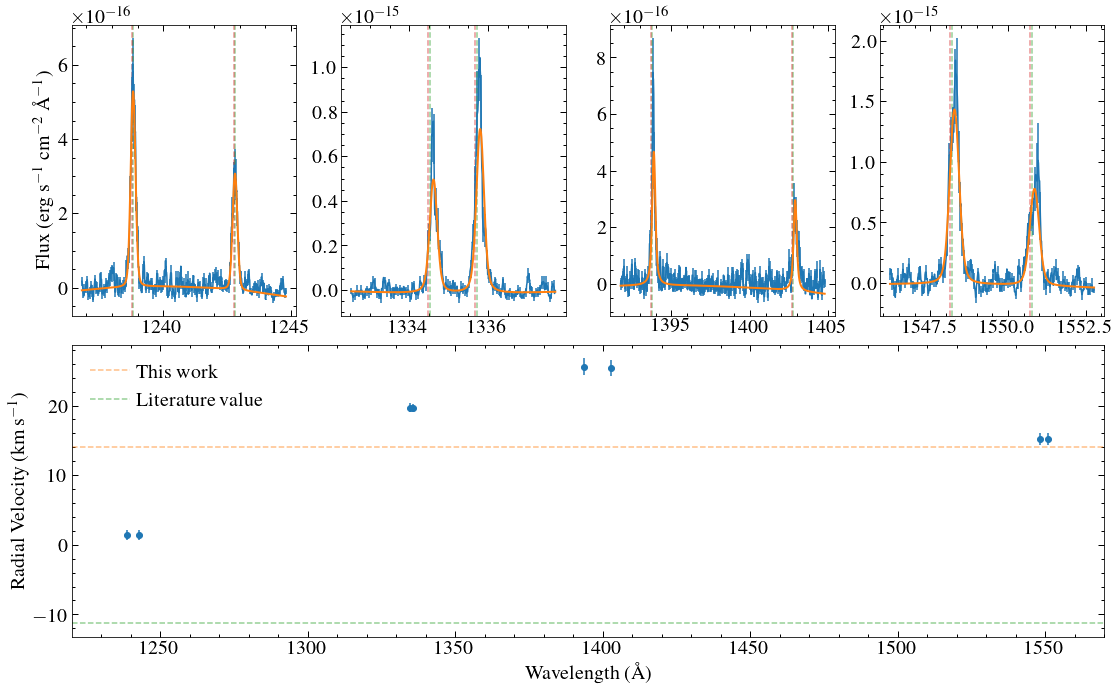

In [11]:
stars = []
final_dv = []
fitter = fitting.LevMarLSQFitter()


doublets = np.array([[1238.821, 1242.804],[1334.524,1335.709],[1393.755,1402.77],[1548.201,1550.772]])
all_lines = doublets.flatten()
names = ['N\,v', 'C\,II', 'Si\,IV', 'C\,IV']

# dv_guess = np.array([0, 0, -10, 0, 0, -10, -90, 10, 0, 0, 0, -50])*u.km/u.s
# ref_dvs = [4.4, -4, 11.6,36.9, -15.3,-2.7, -110.5, -10.5, -15.3,-11.3, -10, -54]
# ['GJ1132', 'GJ15A', 'GJ163', 'GJ649', 'GJ676A', 'GJ699', 'GJ729', 'GJ849', 'LHS-2686', '2MASS-J23062928-0502285', 'GJ674', 'L-980-5']


ref_dvs = [4.4, 11.6,  36.9,4.4,-39.1,-110.5,-10.5, -15.3, -10,-54,-2.7, -11.3]
dv_guess = np.array(ref_dvs)*u.km/u.s

for j, spec in enumerate(specs):
#     print(spec)
    plt.figure(figsize = (4*len(doublets), 10))
    gs = GridSpec(2, 4)
    data = fits.getdata(spec, 1)
    star = fits.getheader(spec)['TARGNAME']
    print(star)
    print(j)
    print(dv_guess[j])
    stars.append(star)
    w, f, e, inst = data['WAVELENGTH'], data['FLUX'], data['ERROR'], data['INSTRUMENT']
    # lines = line_list[(line_list['Likelihood to measure'] == 'High') | (line_list['Likelihood to measure'] == 'Medium')]['Wavelength']

    smooth =7 

    dvs = []
    dv_es = []

    for i, lines in enumerate(doublets):
#         plt.subplot(1, len(doublets) , i+1)
        plt.subplot(gs[0, i])
        if i == 0:
            plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
#         start, end = lines[0]-5, lines[1]+5
        mask = (w >= lines[0]-7) & (w <= lines[1]+7)
        if np.median(inst[mask]) in [1, 2, 16]:
            mask = (w >= lines[0]-2) & (w <= lines[1]+2)
     
            
        wi, fi, ei = w[mask], f[mask], e[mask]
        mod = models.Polynomial1D(2)
        std_guess = 0.5
        if np.median(inst[mask]) in [1, 2, 16]:
            std_guess = 0.1
        if np.median(inst[mask]) in [1, 2]:
            fi = convolve(fi,Box1DKernel(smooth))
            ei = convolve(ei,Box1DKernel(smooth))/smooth**0.5
        plt.errorbar(w[mask], fi, yerr =ei, errorevery=5)
    #         print(std_guess)
        for line in lines:
            line_guess = dv_guess[j].to(u.AA, equivalencies = u.doppler_optical(line*u.AA)).value
#             mod = mod+  models.Gaussian1D(amplitude=np.max(fi)/2, mean = line_guess, stddev=std_guess)
            mod = mod + functional_models.Voigt1D(x_0=line_guess, amplitude_L=np.max(fi), fwhm_G=std_guess, fwhm_L=std_guess)#, bounds=dict(amplitude_L=[0, 1]))
            plt.axvline(line, ls='--', c='C2', alpha =0.5)
            plt.axvline(line_guess, ls='--', c='C3', alpha =0.5)
    
        def tiedfunc0(mod):
            mean = mod.mean_1.value+np.diff(lines)
            return mean
        
        
        def tiedfunc1(mod):
            x_0 = mod.x_0_1.value+np.diff(lines)
            # fwhm_G = mod.fwhm_G_1.value
            return x_0
        
        def tiedfwhmg(mod):
            fwhm_G = mod.fwhm_G_1.value
            return fwhm_G
        
        def tiedfwhml(mod):
            fwhm_L = mod.fwhm_L_1.value
            return fwhm_L
        
        
#         mod.mean_2.tied=tiedfunc0
        mod.x_0_2.tied=tiedfunc1
        mod.fwhm_G_2.tied=tiedfwhmg
        mod.fwhm_L_2.tied=tiedfwhml
        
        gg_fit = fitter(mod, w[mask], fi, weights = 1/ei, maxiter=100000)
        if j == 0:
            print(gg_fit[2])

#         if i == 3 and  np.median(inst[mask]) not in [1, 2, 16]:
#             dvs.append(0)
#             dvs.append(0)
#             dv_es.append(0)
#             dv_es.append(0)
        if type(fitter.fit_info['param_cov']) == np.ndarray:
        #     print('hooray!')
            fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
#             print(fit_e)
#             mean_es = fit_e[4:][::4]
#             print(mean_es)
#             mean_es = fit_e[3:][1::3]

    #       print(gg_fit)
            for i in range(len(lines)):
                mean = gg_fit[i+1].x_0
#                 mean = gg_fit[i+1].mean
#                 mean_e = mean_es[i]
                mean_e = fit_e[3] #for double voights
#                 line_e = 
        #             obs_line = gg_fit[i+1].mean*u.AA

                dv = (mean*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(lines[i]*u.AA))
                eup = ((mean+mean_e)*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(lines[i]*u.AA))
                edo = ((mean-mean_e)*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(lines[i]*u.AA))
                dve= np.mean([abs(dv-eup).value, abs(dv-edo).value])*u.km/u.s   
                print(lines[i], dv, dve)
                dvs.append(dv.value)
                dv_es.append(dve.value)
        else:
            dvs.append(0)
            dvs.append(0)
            dv_es.append(0)
            dv_es.append(0)
   
            
    
        plt.plot(wi, gg_fit(wi), lw=2, zorder=10)
#     plt.savefig('line_plots/{}_lines.pdf'.format(star), dpi=150)
#     plt.show()
    dvs, dv_es = np.array(dvs), np.array(dv_es)
    dv_av = np.average(dvs[dvs !=0], weights = 1/dv_es[dvs !=0]**2)
    final_dv.append(dv_av)
    plt.subplot(gs[1, :])
    plt.errorbar(all_lines[dvs !=0], dvs[dvs !=0], yerr =dv_es[dvs !=0], marker='o', ls='none')
    plt.axhline(dv_av, ls='--', c='C1', alpha=0.5, label='This work')
    plt.axhline(dv_guess[j].value, ls='--', c='C2', alpha=0.5, label='Literature value')
    plt.xlabel('Wavelength (\AA)')
    plt.ylabel('Radial Velocity (km\,s$^{-1}$)')
    plt.legend()
    plt.xlim(1220, 1570)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.2, hspace=0.1)
    plt.savefig('rv_plots/{}_rv.png'.format(star), dpi=150)
    plt.savefig('rv_plots/{}_rv.pdf'.format(star), dpi=150)
    plt.show()
    
    #     start += step


In [12]:
for s, v in zip(stars, final_dv):
    print(s,',', v)

GJ1132 , 39.81718301485894
GJ15A , -8.874938991000736
GJ163 , 27.93788047955458
GJ649 , -3.1819281400571082
GJ676A , -45.14902144328076
GJ699 , -123.77735748267808
GJ729 , 12.466761090271442
GJ849 , -24.495933902330982
LHS-2686 , 5.8648581873290935
2MASS-J23062928-0502285 , -63.11826761903297
GJ674 , -8.617045562209798
L-980-5 , 13.990040227314038


In [91]:
line_groups = np.array([
    [1174.935,1175.265,1175.592,1175.713,1175.989,1176.372],
    [1206.499],
    [1238.821,1242.804],
    [1264.737,1265.001],
    [1294.543],
    [1298.918],
    [1323.952],
    [1334.524, 1335.709],
    [1393.755,1402.77],
    [1548.201,1550.772],
    [1640.332,1640.345,1640.375,1640.391,1640.474,1640.49,1640.533],
    [1656.267,1656.926,1657.008,1657.379,1657.907,1658.122],
    [1670.787],
    [2796.35, 2803.53]], dtype='object')

line_oss = np.array([
    [1.136e-01, 2.724e-01,  6.810e-02, 2.042e-01, 9.074e-02, 6.807e-02],
                    [1.0], 
                    [1.56e-01,7.80e-02],
                    [1.09e+00, 1.13e-01],
                    [1.0],
                    [1.0],
                    [1.0],
                    [1.29e-01, 1.15e-01],
                    [5.13e-01, 2.55e-01],
                    [1.90e-01, 9.52e-02],
                    [6.9591e-01, 2.8995e-01, 1.3592e-02, 1.4498e-01, 6.2629e-01, 6.9588e-02, 1.3593e-02],
                    [5.98e-02, 1.43e-01,1.07e-01, 3.57e-02, 4.77e-02, 3.56e-02],
                    [1.0],
                    [6.08e-01, 3.03e-01]], dtype='object')

# for lines, oss in zip(line_groups, line_oss):
    # print(len(lines), len(oss), np.sum(oss))

6 6 0.81711
1 1 1.0
2 2 0.23399999999999999
2 2 1.203
1 1 1.0
1 1 1.0
1 1 1.0
2 2 0.244
2 2 0.768
2 2 0.2852
7 7 1.853903
6 6 0.4288
1 1 1.0
2 2 0.911


GJ15A
40136.85618875074 2434.080895968464


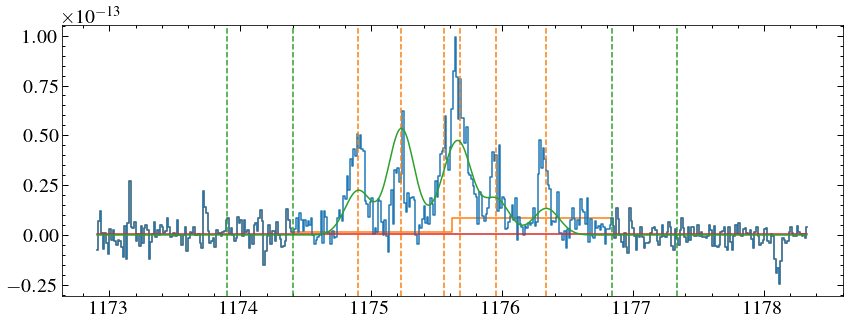

14899.9957616212 1000.6882587033061


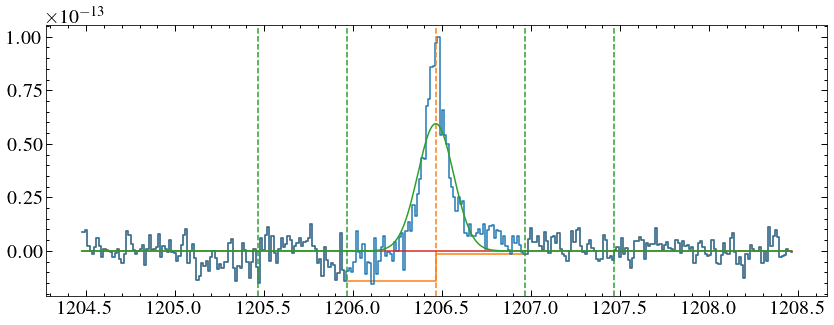

33179.5414215599 968.8277444873803


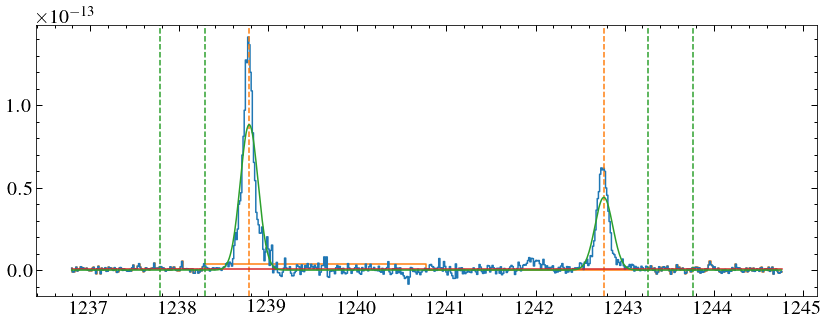

1909.0324871692737 269.0159950600386


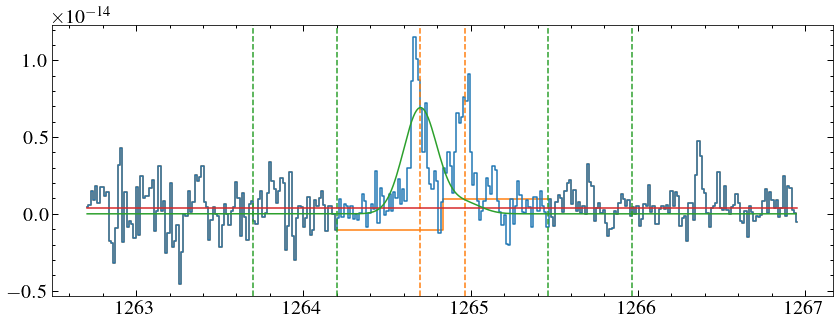

1215.4701704224335 315.4474934118339


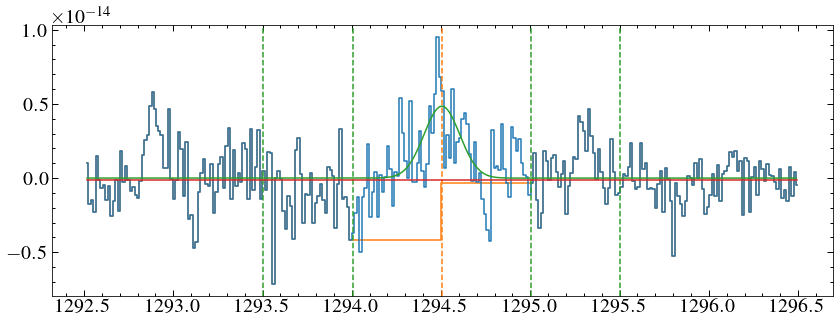

1393.1224396154662 206.11335387233626


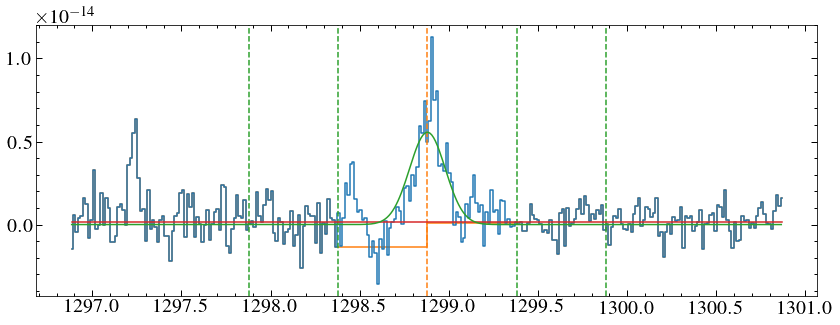

234.18282985660892 211.9252835754358


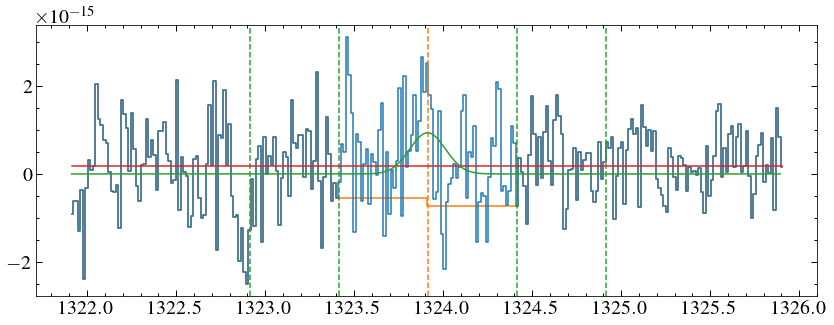

38130.12871468251 580.6762741943683


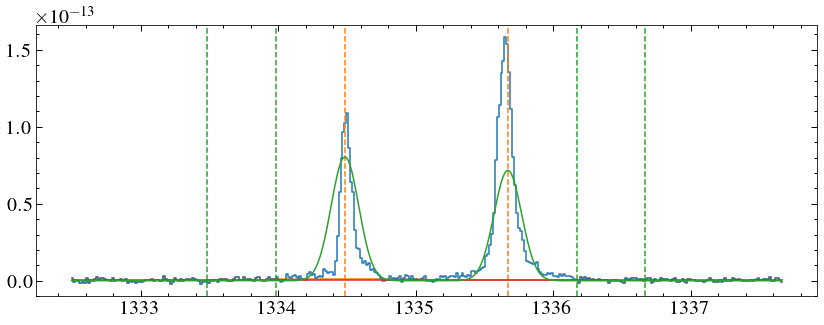

30750.748435357338 1006.3787024064441


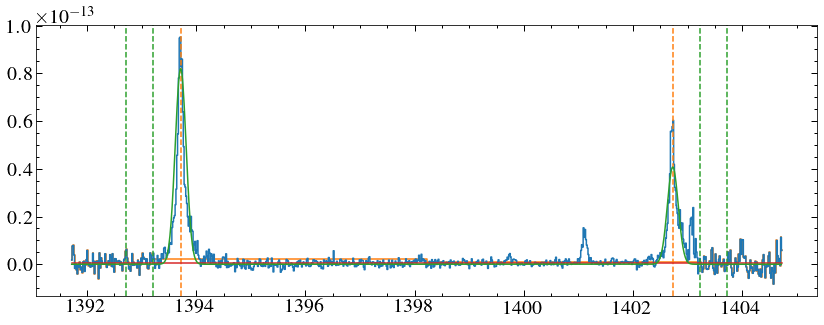

111220.43043567658 2161.1540541207264


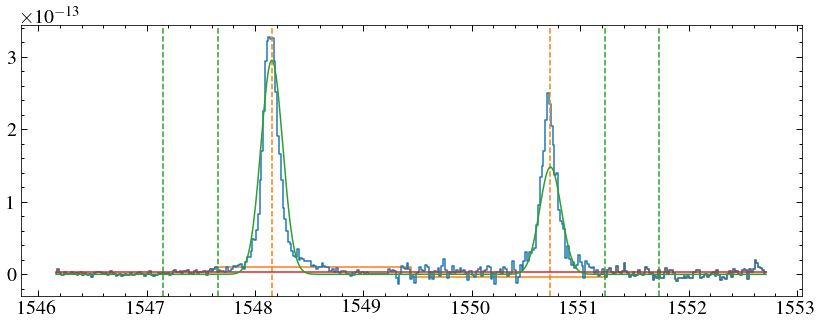

59498.31983463913 1645.9588809094796


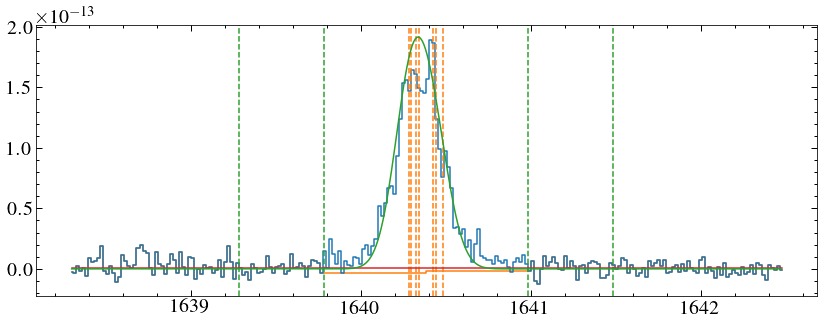

25280.537963485225 2440.4214516079496


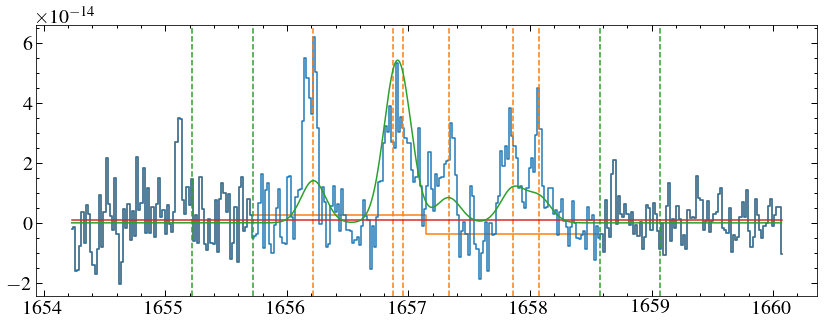

/home/david/anaconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:106: RuntimeWarning: divide by zero encountered in true_divide
/home/david/anaconda3/envs/astroconda/lib/python3.7/site-packages/astropy/modeling/fitting.py:701: RuntimeWarning: invalid value encountered in multiply
  rhs = rhs * weights
/home/david/anaconda3/envs/astroconda/lib/python3.7/site-packages/astropy/modeling/fitting.py:704: RuntimeWarning: invalid value encountered in true_divide
  lhs /= scl


ValueError: Found NaNs in the coefficient matrix, which should not happen and would crash the lapack routine. Maybe check that weights are not null.

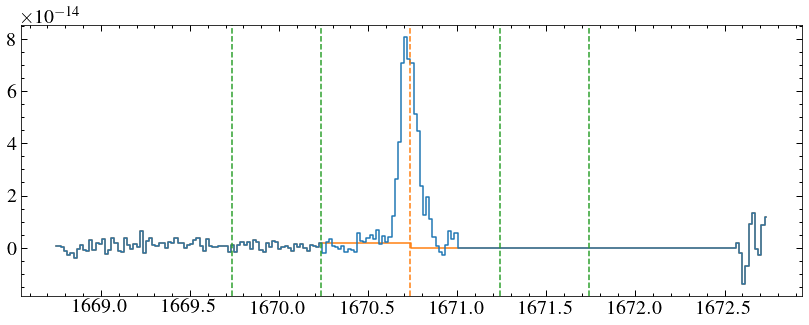

In [95]:
def wavelength_edges(w):
    """
    Calulates w0 and w1
    """
    diff = np.diff(w)
    diff0 = np.concatenate((np.array([diff[0]]), diff)) #adds an extravalue to make len(diff) = len(w)
    diff1 = np.concatenate((diff, np.array([diff[-1]]))) #adds an extravalue to make len(diff) = len(w)
    w0 = w - diff0/2.
    w1 = w + diff1/2.
    return w0, w1

def mask_maker(x, pairs, include=True):
    """
    creates a mask for a spectrum that excudes between pairs from an array
    """
    b = pairs[::2]
    r = pairs[1::2]
    C = np.zeros_like(x,dtype='bool')
    for i in range(len(b)):
        C |= (x>b[i])&(x<r[i])
    if include:
        return ~C
    else:
        return C

def make_line_mask(w, grouped_lines, dv=0*u.km/u.s): 
    """
    makes a list of wavelength ranges to cut
    """
    pairs = []
    for group in grouped_lines:
        group =  dv.to(u.AA, equivalencies=u.doppler_optical(group*u.AA)).value
        pairs.append(min(group)-0.5)    
        pairs.append(max(group)+0.5)
    mask = mask_maker(w, pairs)
    return mask


fitter = fitting.LinearLSQFitter()

for j, spec in enumerate(specs):
#     print(spec)
    # plt.figure(figsize = (4*len(doublets), 10))
    # gs = GridSpec(2, 4)
    data = fits.getdata(spec, 1)
    star = fits.getheader(spec)['TARGNAME']
    if star == 'GJ15A':
        print(star)
        # print(j)
        # print(dv_guess[j])
        # stars.append(star)
        w, f, e, inst = data['WAVELENGTH'], data['FLUX'], data['ERROR'], data['INSTRUMENT']
        # lines = line_list[(line_list['Likelihood to measure'] == 'High') | (line_list['Likelihood to measure'] == 'Medium')]['Wavelength']

        smooth =5 

        # dvs = []
        # dv_es = []

        # for i, lines in enumerate(doublets):
    #         plt.subplot(1, len(doublets) , i+1)
            # plt.subplot(gs[0, i])
        for i, lines in enumerate(line_groups):
            stat_lines = np.copy(lines) 
            lines = (final_dv[j]*u.km/u.s).to(u.AA, equivalencies=u.doppler_optical(lines*u.AA)).value
            mask = (w >= min(lines)-7-7) & (w <= max(lines)+7)
            if np.median(inst[mask]) in [1, 2, 16]:
                mask = (w >= min(lines)-2) & (w <= max(lines)+2)
            elif np.median(inst[mask]) in [128]:
                mask = (w >= min(lines)-20) & (w <= max(lines)+20)
            wi, fi, ei = w[mask], f[mask], e[mask]



            if np.median(inst[mask]) in [1, 2]:
                fi = convolve(fi,Box1DKernel(smooth))
                ei = convolve(ei,Box1DKernel(smooth))/smooth**0.5

            cmask = make_line_mask(wi, line_groups, dv=final_dv[j]*u.km/u.s)
            wc, fc, ec, = wi[cmask], fi[cmask], ei[cmask]
            plt.step(wi, fi, where='mid')
            plt.step(wc, fc, where='mid', zorder=-1)
            [plt.axvline(line, ls='--', c='C1') for line in lines]


            c_gap = [4, 7]#distance from lines for continumm calculation
            # std_guess = 0.5
            if np.median(inst[mask]) in [1, 2, 16]:
                c_gap = [0.5, 1] 
            if np.median(inst[mask]) in [128]:
                c_gap = [10, 15] #distance from lines for continumm calculation

            fit_mask = (wc >= (min(lines)-c_gap[1])) & (wc <= (min(lines)-c_gap[0])) | (wc >= (max(lines)+c_gap[0])) & (wc <= (max(lines)+c_gap[1]))
            linemask = (wi >= (min(lines)-c_gap[0])) & (wi <= (max(lines)+c_gap[0]))


            if 1206.499 in stat_lines: #hits the lower SN G140m spectrum at the red end so cutting off the fit
                fit_mask = (wc >= (min(lines)-2)) & (wc <= (min(lines)-c_gap[0])) 
                linemask = (wi >= (min(lines)-c_gap[0])) & (wi <= (max(lines)+0.3))



            [plt.axvline(line, ls='--', c='C2') for line in [min(lines)-c_gap[1], min(lines)-c_gap[0], max(lines)+c_gap[0], max(lines)+c_gap[1]]]
            # mod_init = models.Polynomial1D(4)
            mod_init = models.Const1D(1)
            mod_fit = fitter(mod_init, wc[fit_mask], fc[fit_mask], weights=1/ec[fit_mask])
            plt.plot(wi, mod_fit(wi), c='C3')

            lw, lf, le = wi[linemask], fi[linemask], ei[linemask]
            # plt.plot(wi[linemask], fi[linemask], c='C4')

            w0, w1 = wavelength_edges(lw)
            lineflux = np.sum((w1-w0)*lf)
            # print(lineflux*1e18)
            # lineflux = np.trapz(lf, lw)
            # print(lineflux*1e18)
            line_error = (np.sum(le**2 * (w1-w0)**2))**0.5
            cflux = np.sum((w1-w0)*mod_fit(lw))
            cerror = (line_error/abs(lineflux))*abs(cflux)
            flux = lineflux - cflux
            flux_error = (line_error**2+cerror**2)**0.5
            print(flux*1e18, flux_error*1e18)

            modlines = models.Const1D(0)
            # modlines = mod_fit
            oss = line_oss[i]
            sum_oss = np.sum(oss)
            # ampsum = 0
            for k, line in enumerate(lines):
                stdmod = 0.1
                fmod = flux * (oss[k]/sum_oss) 
                amp = fmod/(stdmod*(2*np.pi)**0.5)
                # ampsum += amp
                modlines = modlines+models.Gaussian1D(amplitude=amp, mean=line, stddev = stdmod)
            wmod = np.arange(wi[0], wi[-1], 0.01)
            plt.plot(wmod, modlines(wmod))
            
            # line_flux = np.trapz(fi[linemask], wi[linemask])
            # cont_flux = np.trapz(mod_fit(wi[linemask]), wi[linemask])
            # net_flux = line_flux - cont_flux
            # print(line_flux, cont_flux)
            # print(net_flux*1e18)

            # modlines = models.Const1D(0)
            # mod_flux = flux/len(lines) #flux per line
            # mod_amp = mod_flux/(0.1*(2*np.pi)**0.5)
            # mod_w = np.arange(wi[0], wi[-1], 0.01)
            # for line in lines:
            #     modlines = modlines + models.Gaussian1D(amplitude=mod_amp , mean = line, stddev=0.1)
            # plt.plot(mod_w, modlines(mod_w))


            plt.show()

How big is the Mg II line really?

In [22]:
# datah= fits.getdata('/media/david/2tb_ext_hd/hddata/mega_muscles/gj699_e230h/odn904050_x1d.fits',1)
# datal = fits.getdata('/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/GJ699/hlsp_muscles_hst_stis_gj699_g230l_v10_component-spec.fits', 1)

In [23]:
# for dt in datah:
#     plt.step(dt['WAVELENGTH'], dt['FLUX'], where='mid')

# plt.step(datal['WAVELENGTH'], datal['FLUX'], where='mid', lw=2, c='C0')
# plt.xlim(2787, 2801)
# plt.yscale('log')
# plt.ylim(9e-16)

In [24]:
# ((2*np.pi)**0.5)*9.1e-15*0.2

In [25]:
stars

['GJ1132',
 'GJ15A',
 'GJ163',
 'GJ649',
 'GJ676A',
 'GJ699',
 'GJ729',
 'GJ849',
 'LHS-2686',
 '2MASS-J23062928-0502285',
 'GJ674',
 'L-980-5']

In [66]:
g1=  [1.56e-01,7.80e-02]
g2 = [6.9591e-01, 2.8995e-01, 1.3592e-02, 1.4498e-01, 6.2629e-01, 6.9588e-02, 1.3593e-02]

print(g1[0]/g1[1])
print(g2[0]/g2[1])

print(g1[0]/np.sum(g1), g1[1]/np.sum(g1))
print(g2[0]/np.sum(g2), g2[1]/np.sum(g2))
print((g2[0]/np.sum(g2))/(g2[1]/np.sum(g2)))



2.0
2.4001034661148477
0.6666666666666667 0.33333333333333337
0.375375626448633 0.15639976848842682
2.4001034661148477
